In [1]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
import matplotlib.pyplot as plt

In [2]:
def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()

In [ ]:
num_img = len(glob.glob('../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm'))
fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm')):
    dataset = pydicom.dcmread(file_path)
    #show_dcm_info(dataset)
    
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)

In [ ]:
start = 5   # Starting index of images
num_img = 4 # Total number of images to show

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm')[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    #show_dcm_info(dataset)
    
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)

In [ ]:
df = pd.read_csv('../input/siim-acr-pneumothorax-segmentation/sample images/train-rle-sample.csv', header=None, index_col=0)

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm')[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    #print(file_path.split('/')[-1][:-4])
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    if df.loc[file_path.split('/')[-1][:-4],1] != '-1':
        mask = rle2mask(df.loc[file_path.split('/')[-1][:-4],1], 1024, 1024).T
        ax[q].set_title('See Marker')
        ax[q].imshow(mask, alpha=0.3, cmap="Reds")
    else:
        ax[q].set_title('Nothing to see')

In [ ]:
train_glob = '../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-train/*/*/*.dcm'
test_glob = '../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-test/*/*/*.dcm'
train_fns = sorted(glob.glob(train_glob))[:5000]
test_fns = sorted(glob.glob(test_glob))[:5000]
df_full = pd.read_csv('../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/train-rle.csv', index_col='ImageId')

In [ ]:
im_height = 1024
im_width = 1024
im_chan = 1
# Get train images and masks
X_train = np.zeros((len(train_fns), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_fns), im_height, im_width, 1), dtype=np.bool)
print('Getting train images and masks ... ')
sys.stdout.flush()
for n, _id in tqdm_notebook(enumerate(train_fns), total=len(train_fns)):
    dataset = pydicom.read_file(_id)
    X_train[n] = np.expand_dims(dataset.pixel_array, axis=2)
    try:
        if '-1' in df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
            Y_train[n] = np.zeros((1024, 1024, 1))
        else:
            if type(df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']) == str:
                Y_train[n] = np.expand_dims(rle2mask(df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels'], 1024, 1024), axis=2)
            else:
                Y_train[n] = np.zeros((1024, 1024, 1))
                for x in df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
                    Y_train[n] =  Y_train[n] + np.expand_dims(rle2mask(x, 1024, 1024), axis=2)
    except KeyError:
        print(f"Key {_id.split('/')[-1][:-4]} without mask, assuming healthy patient.")
        Y_train[n] = np.zeros((1024, 1024, 1)) # Assume missing masks are empty masks.

print('Done!')

In [ ]:
im_height = 128
im_width = 128
im_chan = 1
X_train = X_train.reshape((-1, im_height, im_width, 1))
Y_train = Y_train.reshape((-1, im_height, im_width, 1))

In [11]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_99 (Conv2D)             (None, 256, 256, 16  160         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_49 (Dropout)           (None, 256, 256, 16  0           ['conv2d_99[0][0]']              
                                )                                                           

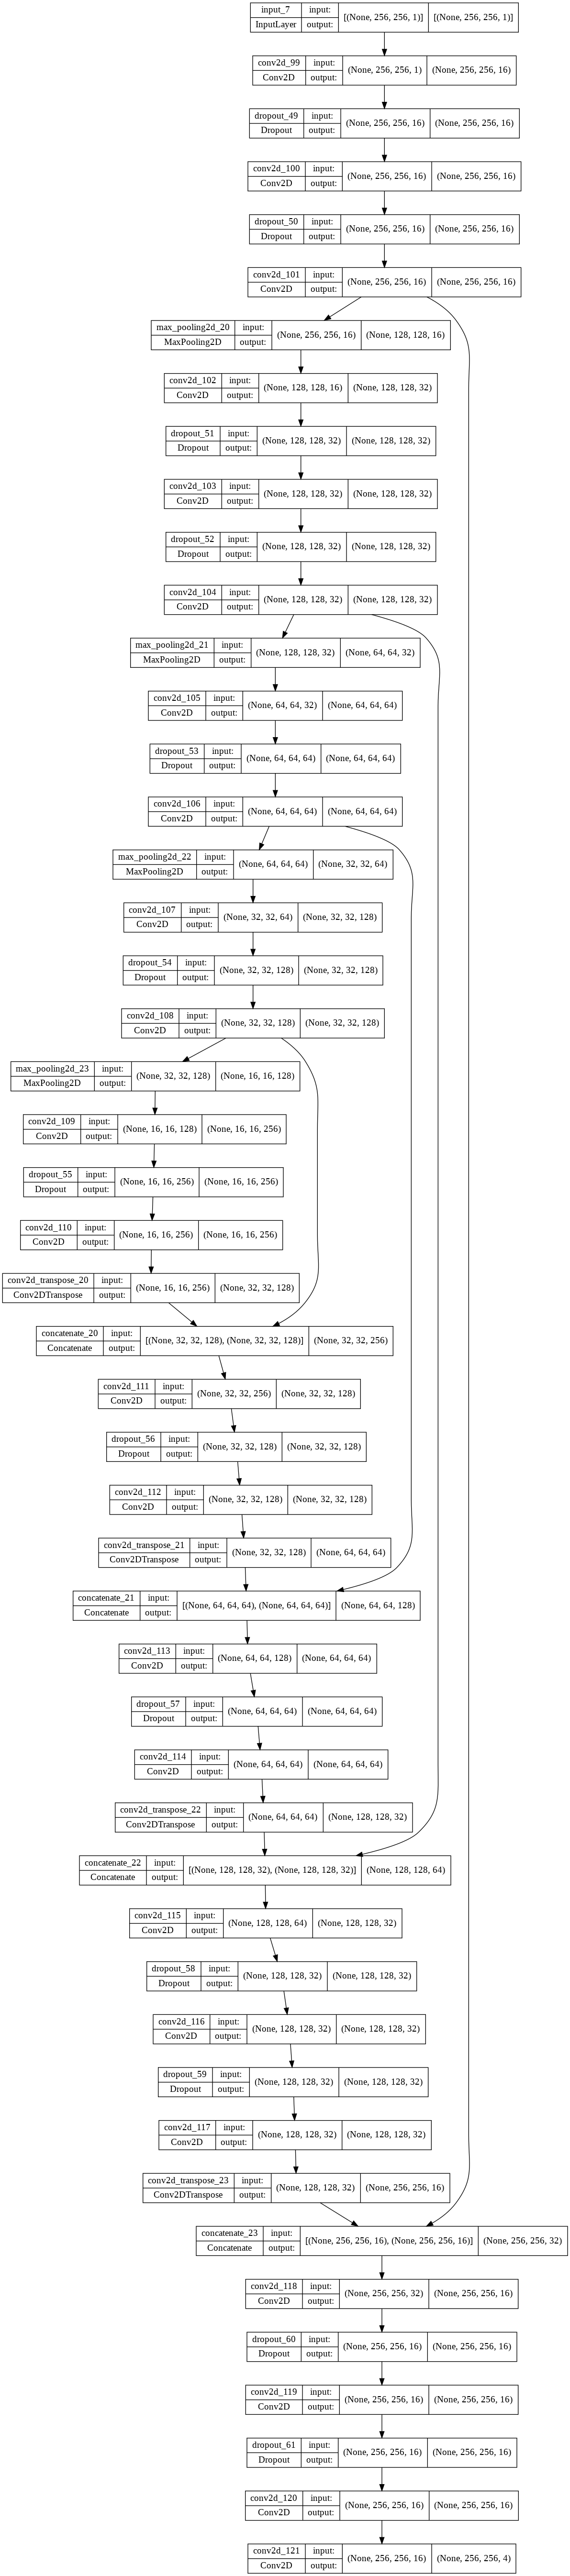

In [13]:

inputs = Input((None,None,im_chan))
s = inputs
# Build the model

#def build_unet_model(n_classes,IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS ):
    
    # Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='softmax')(c9)
    unet_model = Model(inputs=[inputs], outputs=[outputs])
    unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    unet_model.summary()

#unet_model = build_unet_model(4,256,256,1)

tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [8]:
unet_model.fit(X_train, Y_train, validation_split=.2, batch_size=512, epochs=30)